# Zero-noise extrapolation via quantum circuit unoptimization

Code that implements the elementary recipe from "Quantum Circuit Unoptimization" ([arXiv:2311.03805](https://arxiv.org/pdf/2311.03805)).

**Idea**: ZNE is a quantum error mitigation technique that involves running the same circuit at different noise levels and extrapolating the results to estimate the zero-noise limit. It relies on artificially amplifying the noise in the circuit and fitting the results to a model. 

Unoptimizing a circuit increases its depth and gate count, which can lead to higher noise due to increased opportunities for errors. By deliberately adding gates that do not change the overall computation, we can amplify the noise without altering the circuit's functionality.

## Preliminaries

In [119]:
import numpy as np
import random
import warnings

import mitiq
from mitiq.zne.scaling import fold_global

import qiskit
import qiskit_aer
from qiskit_aer.noise import depolarizing_error, NoiseModel
from qiskit_aer import AerSimulator

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import random_unitary, Operator
from qiskit.transpiler import PassManager, passes

First, we need a way of generating a random circuit consisting of two-qubit gates.

In [120]:
def random_two_qubit_circuit(num_qubits: int, depth: int) -> QuantumCircuit:
    """Generate a random quantum circuit with two-qubit gates.

    Args:
        num_qubits: The number of qubits in the circuit.
        depth: The number of layers (depth) of two-qubit gates.

    Returns:
        The generated random circuit.
    """
    qc = QuantumCircuit(num_qubits)

    # Map gate names to their corresponding methods
    gate_map = {
        "cx": qc.cx,
        "cz": qc.cz,
        "swap": qc.swap,
        "iswap": qc.iswap
    }

    for _ in range(depth):
        qubit1, qubit2 = random.sample(range(num_qubits), 2)
        gate = random.choice(list(gate_map.keys()))
        gate_map[gate](qubit1, qubit2)

    return qc

As an example, here is randomly generated 5-qubit and depth-10 circuit consisting of two-qubit gates 

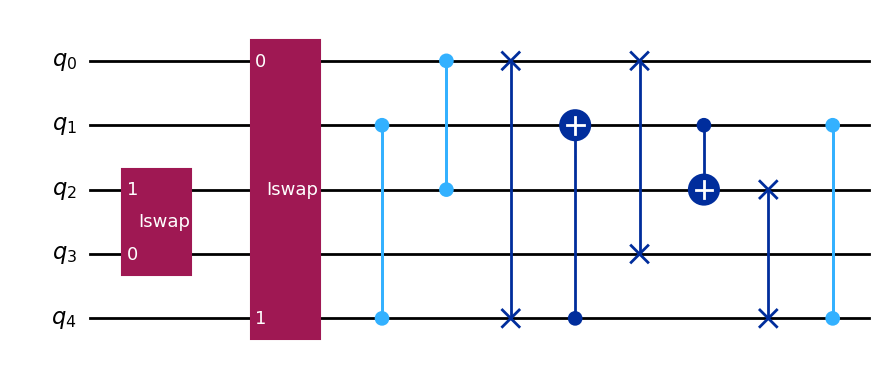

In [121]:
num_qubits = 5
depth = 10
random_circuit = random_two_qubit_circuit(num_qubits, depth)

random_circuit.draw("mpl")

## Elementary recipe

The elementary recipe (ER) for quantum circuit unoptimization is given by Figure-1 in [arXiv:2311.03805](https://arxiv.org/pdf/2311.03805). The ER contains the following steps (applied in the following order):

1. Gate insertion
2. Gate swapping
3. Gate decomposition
4. Gate synthesis

### Gate insertion

In [122]:
def gate_insert(qc: QuantumCircuit, strategy="P_c"):
    """Insert a two-qubit gate A and its Hermitian conjugate A† between two gates B1 and B2.

    Args:
        qc: The input quantum circuit.
        strategy: The strategy to select the pair of two-qubit gates. Options are "P_c" or "P_r".

    Returns:
        new_qc: The modified quantum circuit with A and A† inserted.
        B1_info: Information about gate B1 (index, qubits, gate).
    """
    # Collect all two-qubit gates with their indices and qubits
    two_qubit_gates = []
    for idx, instruction in enumerate(qc.data):
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        if len(qargs) == 2:
            qubit_indices = [qc.find_bit(qarg).index for qarg in qargs]
            two_qubit_gates.append({"index": idx, "qubits": qubit_indices, "gate": instr})

    found_pair = False
    B1_idx = B1_qubits = B1_gate = shared_qubit = None

    if strategy == "P_c":
        # Strategy P_c: Find a pair of gates that share a common qubit
        for i in range(len(two_qubit_gates)):
            for j in range(i+1, len(two_qubit_gates)):
                qubits_i = set(two_qubit_gates[i]["qubits"])
                qubits_j = set(two_qubit_gates[j]["qubits"])
                common_qubits = qubits_i & qubits_j
                if len(common_qubits) == 1:
                    B1_idx = two_qubit_gates[i]["index"]
                    B1_qubits = two_qubit_gates[i]["qubits"]
                    B1_gate = two_qubit_gates[i]["gate"]
                    shared_qubit = list(common_qubits)[0]
                    found_pair = True
                    break
            if found_pair:
                break
    elif strategy == "P_r":
        # Strategy P_r: Randomly select a two-qubit gate as B1
        if two_qubit_gates:
            gate_info = random.choice(two_qubit_gates)
            B1_idx = gate_info["index"]
            B1_qubits = gate_info["qubits"]
            B1_gate = gate_info["gate"]
            shared_qubit = B1_qubits[0]  # Choose the first qubit as shared
            found_pair = True
    else:
        raise ValueError(f"Unknown strategy '{strategy}'. Available strategies are 'P_c' and 'P_r'.")

    if not found_pair:
        warnings.warn("No suitable pair of two-qubit gates found. Skipping gate insertion.")
        return qc, None  # Return the original circuit unmodified

    # Generate a random two-qubit unitary A and its adjoint A†
    A = random_unitary(4)
    A_dag = A.adjoint()

    # Choose qubits for A and A† insertion
    all_qubits = set(range(qc.num_qubits))
    other_qubits = list(all_qubits - set(B1_qubits))
    if not other_qubits:
        warnings.warn("Not enough qubits to perform gate insertion. Skipping.")
        return qc, None  # Return the original circuit unmodified
    third_qubit = other_qubits[0]
    shared_qubit = shared_qubit

    # Map indices back to qubits
    qubit_map = {qc.find_bit(q).index: q for q in qc.qubits}

    # Create a new circuit and insert A and A†
    new_qc = QuantumCircuit(*qc.qregs, *qc.cregs)

    # Copy the gates up to and including B1
    for instruction in qc.data[:B1_idx+1]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Insert A on qubits [shared_qubit, third_qubit]
    qubits_for_A = [qubit_map[shared_qubit], qubit_map[third_qubit]]
    new_qc.unitary(A, qubits_for_A, label="A")

    # Insert A† on the same qubits
    new_qc.unitary(A_dag, qubits_for_A, label="A†")

    # Copy the remaining gates
    for instruction in qc.data[B1_idx+1:]:
        instr = instruction.operation
        qargs = instruction.qubits
        cargs = instruction.clbits
        new_qc.append(instr, qargs, cargs)

    # Prepare B1_info for gate_swap function
    B1_info = {
        "index": B1_idx,
        "qubits": B1_qubits,
        "gate": B1_gate,
        "shared_qubit": shared_qubit,
        "third_qubit": third_qubit,
        "A": A,
        "A_dag": A_dag
    }

    return new_qc, B1_info

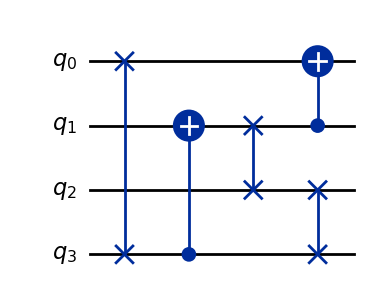

In [123]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

qc.draw("mpl")

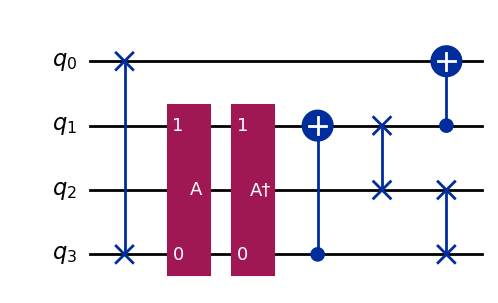

In [124]:
# Perform gate insertion
inserted_qc, B1_info = gate_insert(qc)

inserted_qc.draw("mpl")

In [125]:
original_unitary = Operator(qc)
unoptimized_unitary = Operator(inserted_qc)

unitaries_are_equal = original_unitary.equiv(unoptimized_unitary)
print(f"Are the circuits functionally equivalent: {unitaries_are_equal}")

Are the circuits functionally equivalent: True


### Gate swapping

In [126]:
def gate_swap(qc: QuantumCircuit, B1_info: dict) -> QuantumCircuit:
    """Swap the B1 gate with the A† gate in the circuit.

    Args:
        qc: The input quantum circuit.
        B1_info: Information about gate B1, including its index, qubits, and the A, A† gates.

    Returns:
        new_qc: The modified quantum circuit with B1 and A† swapped.
    """
    B1_idx = B1_info["index"]
    B1_qubits = B1_info["qubits"]
    A = B1_info["A"]
    A_dag = B1_info["A_dag"]
    shared_qubit = B1_info["shared_qubit"]
    third_qubit = B1_info["third_qubit"]

    # Indices for A and A† in the circuit
    A_idx = B1_idx + 1  # A is inserted right after B1
    A_dag_idx = B1_idx + 2  # A† is inserted after A

    # Create a new quantum circuit
    new_qc = QuantumCircuit(*qc.qregs, *qc.cregs)

    # Iterate through the circuit data and swap B1 and A†
    for i, instruction in enumerate(qc.data):
        if i == B1_idx:
            # Insert A† at the position of B1 (swap)
            qubits_for_A_dag = [qc.qubits[shared_qubit], qc.qubits[third_qubit]]
            new_qc.unitary(A_dag, qubits_for_A_dag, label="A†")
        elif i == A_dag_idx:
            # Insert B1 gate at the position where A† was
            new_qc.append(B1_info["gate"], [qc.qubits[q] for q in B1_qubits])
        else:
            # Copy the other gates as they are
            new_qc.append(instruction.operation, instruction.qubits, instruction.clbits)

    return new_qc

In [127]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)
swapped_qc = gate_swap(inserted_qc, B1_info)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)
unoptimized_unitary_swap = Operator(swapped_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)
unitaries_are_equal_swap = original_unitary.equiv(unoptimized_unitary_swap)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")
print(f"Are the circuits functionally equivalent (after swap)? {unitaries_are_equal_swap}")

Are the circuits functionally equivalent (after insert)? True
Are the circuits functionally equivalent (after swap)? True


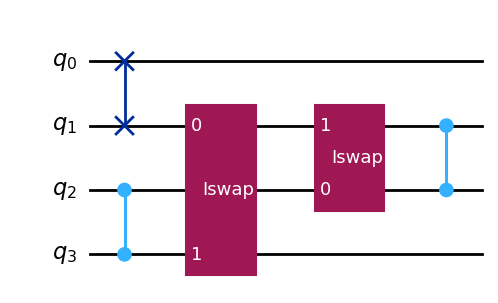

In [128]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

qc.draw("mpl")

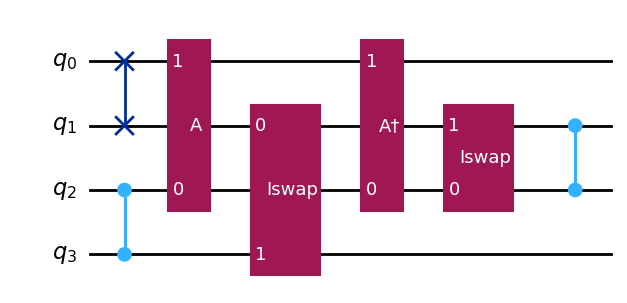

In [129]:
# Perform gate insertion using P_r strategy
inserted_qc, B1_info = gate_insert(qc, strategy="P_r")

inserted_qc.draw("mpl")

Circuit after applying ER with P_r strategy:


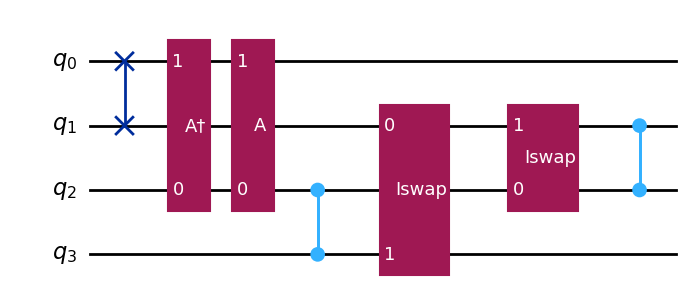

In [130]:
# Perform gate swapping
final_qc = gate_swap(inserted_qc, B1_info)

print("Circuit after applying ER with P_r strategy:")
final_qc.draw("mpl")

### Gate decomposition

In [131]:
def decompose_circuit(qc: QuantumCircuit):
    """Decompose multi-qubit unitary gates into elementary gates.

    Args:
        qc: The quantum circuit to decompose.

    Returns:
        new_qc: The decomposed quantum circuit.
    """
    # Use transpile with decomposition
    decomposed_qc = transpile(qc, basis_gates=["u1", "u2", "u3", "cx"], optimization_level=0)
    return decomposed_qc

In [132]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)
swapped_qc = gate_swap(inserted_qc, B1_info)
decomposed_qc = decompose_circuit(swapped_qc)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)
unoptimized_unitary_swap = Operator(swapped_qc)
unoptimized_unitary_decompose = Operator(decomposed_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)
unitaries_are_equal_swap = original_unitary.equiv(unoptimized_unitary_swap)
unitaries_are_equal_decompose = original_unitary.equiv(unoptimized_unitary_decompose)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")
print(f"Are the circuits functionally equivalent (after swap)? {unitaries_are_equal_swap}")
print(f"Are the circuits functionally equivalent (after decompose)? {unitaries_are_equal_decompose}")

Are the circuits functionally equivalent (after insert)? True
Are the circuits functionally equivalent (after swap)? True
Are the circuits functionally equivalent (after decompose)? True


### Gate synthesis

In [133]:
def synthesize_circuit(qc: QuantumCircuit, optimization_level: int = 1) -> QuantumCircuit:
    """Synthesize the circuit using a specified optimization level.

    Args:
        qc: The quantum circuit to synthesize.
        optimization_level: The optimization level for transpilation.

    Returns:
        new_qc: The synthesized quantum circuit.
    """
    # Transpile the circuit to synthesize it
    new_qc = transpile(qc, optimization_level=optimization_level, basis_gates=["u1", "u2", "u3", "cx"])
    return new_qc

In [134]:
qc = random_two_qubit_circuit(4, 5)
inserted_qc, B1_info = gate_insert(qc)
swapped_qc = gate_swap(inserted_qc, B1_info)
decomposed_qc = decompose_circuit(swapped_qc)
synthesized_qc = synthesize_circuit(decomposed_qc)

original_unitary = Operator(qc)
unoptimized_unitary_insert = Operator(inserted_qc)
unoptimized_unitary_swap = Operator(swapped_qc)
unoptimized_unitary_decompose = Operator(decomposed_qc)
unoptimized_unitary_synthesize = Operator(synthesized_qc)

unitaries_are_equal_insert = original_unitary.equiv(unoptimized_unitary_insert)
unitaries_are_equal_swap = original_unitary.equiv(unoptimized_unitary_swap)
unitaries_are_equal_decompose = original_unitary.equiv(unoptimized_unitary_decompose)
unitaries_are_equal_synthesize = original_unitary.equiv(unoptimized_unitary_synthesize)

print(f"Are the circuits functionally equivalent (after insert)? {unitaries_are_equal_insert}")
print(f"Are the circuits functionally equivalent (after swap)? {unitaries_are_equal_swap}")
print(f"Are the circuits functionally equivalent (after decompose)? {unitaries_are_equal_decompose}")
print(f"Are the circuits functionally equivalent (after synthesize)? {unitaries_are_equal_synthesize}")

Are the circuits functionally equivalent (after insert)? True
Are the circuits functionally equivalent (after swap)? True
Are the circuits functionally equivalent (after decompose)? True
Are the circuits functionally equivalent (after synthesize)? True


### Putting it all together: Applying the elementary recipe

In [135]:
def elementary_recipe(qc: QuantumCircuit, iterations=1, strategy="P_c"):
    """Apply the elementary recipe to a quantum circuit multiple times.

    Args:
        qc: The input quantum circuit.
        iterations: The number of times to apply the recipe.
        strategy: The strategy used in gate insertion. Options are "P_c" or "P_r".

    Returns:
        new_qc: The quantum circuit after applying the recipe.
    """
    new_qc = qc.copy()
    for _ in range(iterations):
        # Step 1: Gate Insertion
        new_qc, B1_info = gate_insert(new_qc, strategy)

        # Step 2: Gate Swapping
        new_qc = gate_swap(new_qc, B1_info)

        # Step 3: Decomposition
        new_qc = decompose_circuit(new_qc)

        # Step 4: Synthesis
        new_qc = synthesize_circuit(new_qc)

    return new_qc

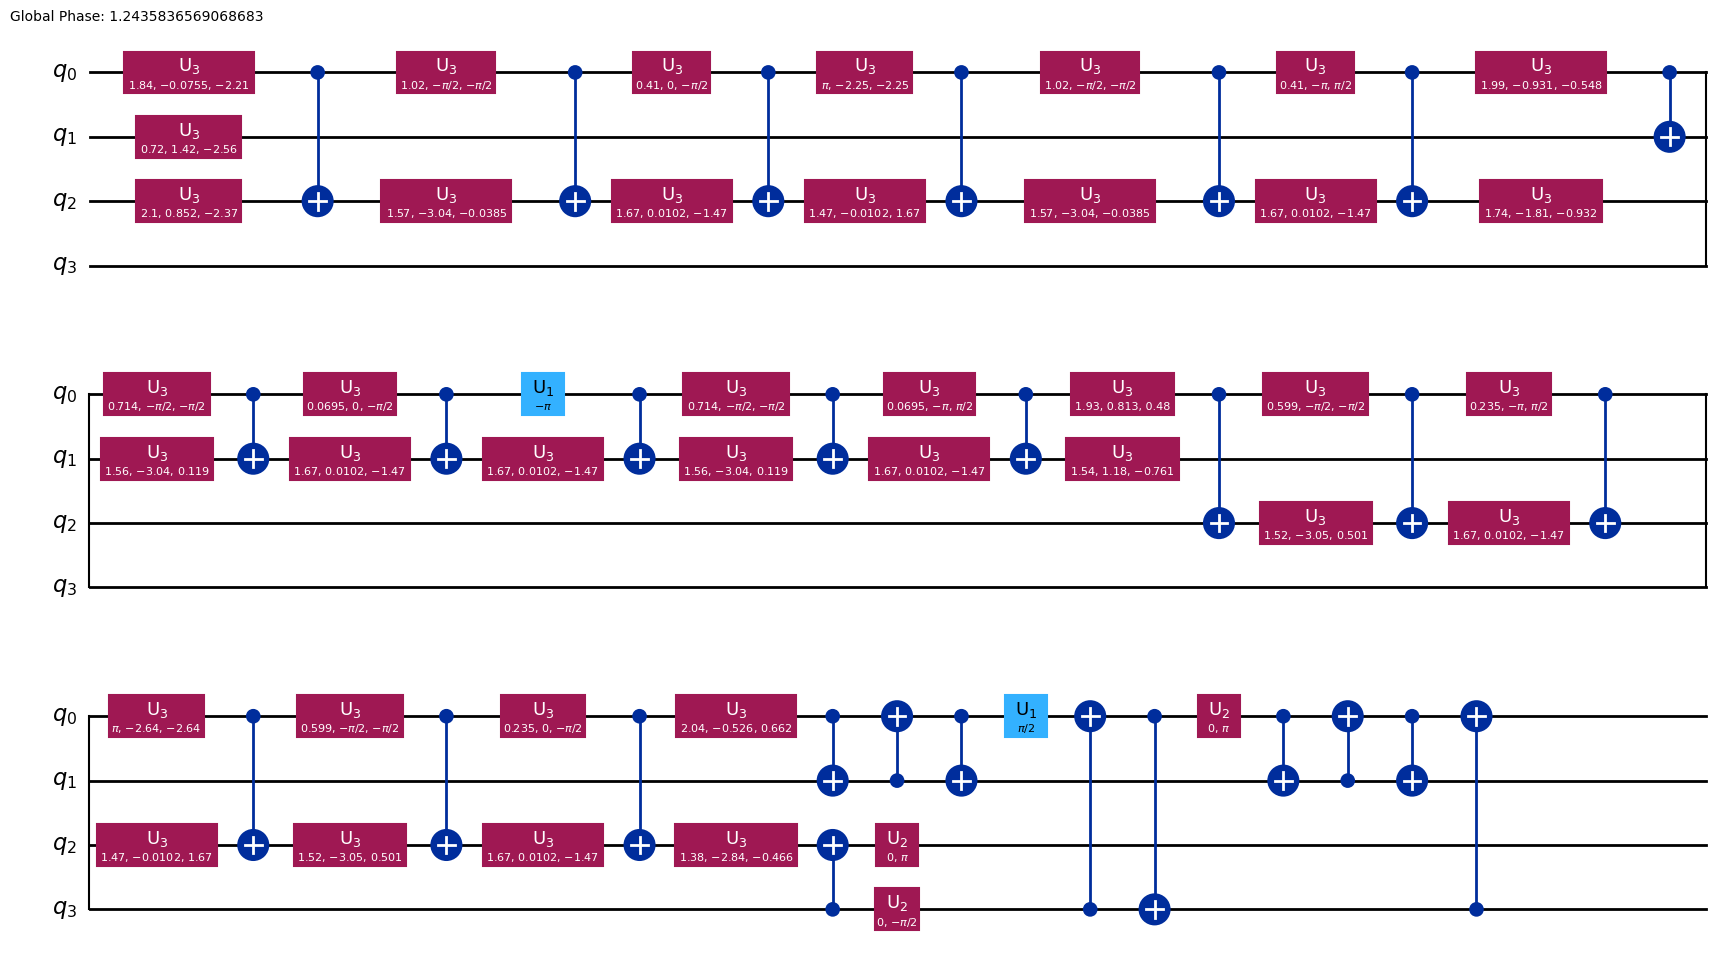

In [136]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)

# Apply the elementary recipe 3 times
final_qc = elementary_recipe(qc, iterations=3)

# Print the final circuit
final_qc.draw("mpl")

In [137]:
qc = random_two_qubit_circuit(4, 5)
final_qc = elementary_recipe(qc, iterations=4)

original_unitary = Operator(qc)
final_unitary = Operator(final_qc)

unitaries_are_equal = original_unitary.equiv(final_unitary)

print(f"Are the circuits functionally equivalent? {unitaries_are_equal}")

Are the circuits functionally equivalent? True


## QEM and Quantum Circuit Unoptimization

By unoptimizing the circuit using the `elementary_recipe`, we can create versions of the circuit with higher noise levels. Mitiq can be used to systematically scale the noise and perform the extrapolation. The unoptimized circuits can serve as intermediate noise levels for ZNE.

In [152]:
def executor(circuit):
    simulator = AerSimulator()
    
    # Add a noise model if desired
    noise_model = NoiseModel()
    error = depolarizing_error(0.01, 1)
    noise_model.add_all_qubit_quantum_error(error, ["u"])
    error_cx = depolarizing_error(0.02, 2)
    noise_model.add_all_qubit_quantum_error(error_cx, ["cx"])

    # Create a copy of the circuit to avoid modifying the original
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Transpile the circuit for the simulator backend
    compiled_circuit = transpile(circuit_to_run, simulator, basis_gates=["u1", "u2", "u3", "cx"])
    
    # Execute the circuit
    result = simulator.run(compiled_circuit, noise_model=noise_model).result()
    counts = result.get_counts()

    # Calculate expectation value of Z on qubit 0
    total_counts = sum(counts.values())
    expectation = 0.0
    for outcome, count in counts.items():
        # Reverse the outcome string due to Qiskit's little-endian ordering
        bitstring = outcome[::-1]
        if bitstring[0] == "0":
            expectation += count / total_counts
        else:
            expectation -= count / total_counts
    return expectation

In [156]:
# Generate a random two-qubit circuit
qc = random_two_qubit_circuit(4, 5)
unoptimized_qc = elementary_recipe(qc, iterations=8)

# Test the execute_circuit function
expectation_qc = execute_circuit(qc)
expectation_unoptimized_qc = execute_circuit(unoptimized_qc)

print(f"Expectation value of original circuit: {expectation_qc}")
print(f"Expectation value of unoptimized circuit: {expectation_unoptimized_qc}")

Expectation value of original circuit: 0.96875
Expectation value of unoptimized circuit: 0.3359375


In [160]:
print(qc)
mitigated_result = mitiq.zne.execute_with_zne(unoptimized_qc, executor)

print(f"Zero-noise extrapolated expectation value: {mitigated_result}")

     ┌───┐   ┌───┐        
q_0: ┤ X ├───┤ X ├────────
     └─┬─┘   └─┬─┘   ┌───┐
q_1: ──■───■───┼─────┤ X ├
           │   │     └─┬─┘
q_2: ──────┼───■───X───■──
           │       │      
q_3: ──────■───────X──────
                          
Zero-noise extrapolated expectation value: 0.5722656250000002
